# Entrenamiento de Modelo U-Net para Segmentación de Pólipos

Este notebook documenta el proceso completo de **entrenamiento de un modelo de Deep Learning
basado en la arquitectura U-Net** para la segmentación automática de pólipos en imágenes endoscópicas.

El objetivo es:
- Reproducir el entrenamiento del modelo a partir del código original.
- Utilizar un dataset real (Kvasir-SEG).
- Guardar el modelo entrenado.
- Generar evidencia técnica del entrenamiento (gráficas y métricas).

Este entrenamiento será utilizado posteriormente en una **aplicación web basada en FastAPI**.


In [6]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
!unzip "/content/drive/MyDrive/Codes for UNET 7.8 - Polyp Segmentation.zip"


Archive:  /content/drive/MyDrive/Codes for UNET 7.8 - Polyp Segmentation.zip
   creating: Polyp Segmentation/
   creating: Polyp Segmentation/.ipynb_checkpoints/
  inflating: Polyp Segmentation/.ipynb_checkpoints/1 - Data-Processing-checkpoint.ipynb  
  inflating: Polyp Segmentation/.ipynb_checkpoints/2 - Training-checkpoint.ipynb  
  inflating: Polyp Segmentation/.ipynb_checkpoints/3 - Predict Mask-checkpoint.ipynb  
  inflating: Polyp Segmentation/.ipynb_checkpoints/4 - Evaluation-checkpoint.ipynb  
  inflating: Polyp Segmentation/.ipynb_checkpoints/5 - Polyp Segmentation-checkpoint.ipynb  
  inflating: Polyp Segmentation/1 - Data-Processing.ipynb  
  inflating: Polyp Segmentation/2 - Training.ipynb  
  inflating: Polyp Segmentation/3 - Predict Mask.ipynb  
  inflating: Polyp Segmentation/4 - Evaluation.ipynb  
  inflating: Polyp Segmentation/5 - Polyp Segmentation.ipynb  
   creating: Polyp Segmentation/dataset/
   creating: Polyp Segmentation/dataset/test/
   creating: Polyp Segmen

In [9]:
%cd "Polyp Segmentation"
!ls


/content/unet-polyp-segmentation-saas/Polyp Segmentation
'1 - Data-Processing.ipynb'  '5 - Polyp Segmentation.ipynb'   prediction
'2 - Training.ipynb'	      dataset			      test-images
'3 - Predict Mask.ipynb'      files
'4 - Evaluation.ipynb'	      Kvasir-SEG


In [10]:
import os
print("Directorio actual:", os.getcwd())
print("Contenido:", os.listdir())


Directorio actual: /content/unet-polyp-segmentation-saas/Polyp Segmentation
Contenido: ['5 - Polyp Segmentation.ipynb', '3 - Predict Mask.ipynb', 'prediction', '1 - Data-Processing.ipynb', 'dataset', 'test-images', '4 - Evaluation.ipynb', '2 - Training.ipynb', '.ipynb_checkpoints', 'files', 'Kvasir-SEG']


In [11]:
DATASET_PATH = "Kvasir-SEG"
IMAGES_DIR = os.path.join(DATASET_PATH, "images")
MASKS_DIR  = os.path.join(DATASET_PATH, "masks")

print("Número de imágenes:", len(os.listdir(IMAGES_DIR)))
print("Número de máscaras:", len(os.listdir(MASKS_DIR)))


Número de imágenes: 1000
Número de máscaras: 1000


## Preparación del dataset

Se utilizaron las carpetas `images` y `masks` del dataset Kvasir-SEG,
verificando que ambas contengan la misma cantidad de archivos,
lo cual garantiza una correcta correspondencia imagen–máscara.


In [12]:
!pip install -q tensorflow opencv-python matplotlib scikit-learn


In [13]:
import numpy as np
import tensorflow as tf
import random

SEED = 42
IMG_SIZE = 256
BATCH_SIZE = 8
EPOCHS = 10
LR = 1e-4

np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)


In [14]:
import cv2

def load_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return img / 255.0

def load_mask(path):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
    mask = (mask > 127).astype(np.float32)
    return mask[..., None]


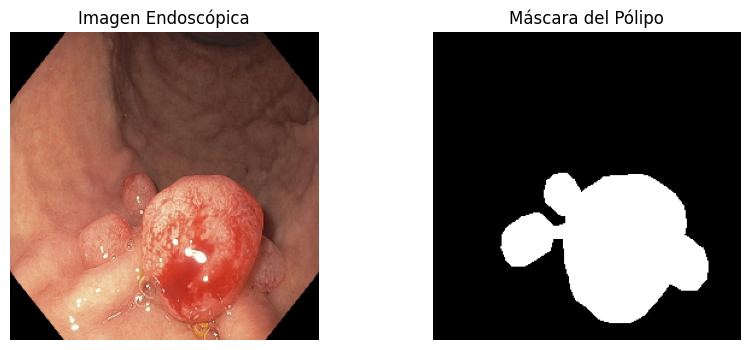

In [15]:
import matplotlib.pyplot as plt

sample = os.listdir(IMAGES_DIR)[0]

img = load_image(os.path.join(IMAGES_DIR, sample))
mask = load_mask(os.path.join(MASKS_DIR, sample))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Imagen Endoscópica")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask.squeeze(), cmap="gray")
plt.title("Máscara del Pólipo")
plt.axis("off")
plt.show()


In [16]:
from sklearn.model_selection import train_test_split

images = sorted(os.listdir(IMAGES_DIR))
masks  = sorted(os.listdir(MASKS_DIR))

train_x, val_x, train_y, val_y = train_test_split(
    images, masks, test_size=0.2, random_state=SEED
)

print("Entrenamiento:", len(train_x))
print("Validación:", len(val_x))


Entrenamiento: 800
Validación: 200


In [17]:
def generator(img_list, mask_list):
    for i, m in zip(img_list, mask_list):
        img = load_image(os.path.join(IMAGES_DIR, i))
        mask = load_mask(os.path.join(MASKS_DIR, m))
        yield img, mask

train_ds = tf.data.Dataset.from_generator(
    lambda: generator(train_x, train_y),
    output_types=(tf.float32, tf.float32),
    output_shapes=((IMG_SIZE, IMG_SIZE, 3), (IMG_SIZE, IMG_SIZE, 1))
).batch(BATCH_SIZE)

val_ds = tf.data.Dataset.from_generator(
    lambda: generator(val_x, val_y),
    output_types=(tf.float32, tf.float32),
    output_shapes=((IMG_SIZE, IMG_SIZE, 3), (IMG_SIZE, IMG_SIZE, 1))
).batch(BATCH_SIZE)


## Arquitectura del modelo U-Net

Se implementa un modelo U-Net con capas convolucionales
y conexiones tipo *skip*, adecuado para tareas de segmentación biomédica.


In [20]:
from tensorflow.keras import layers, Model

def conv_block(x, f):
    x = layers.Conv2D(f, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(f, 3, padding="same", activation="relu")(x)
    return x

def build_unet():
    inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))

    # Encoder
    c1 = conv_block(inputs, 64)
    p1 = layers.MaxPooling2D()(c1)

    c2 = conv_block(p1, 128)
    p2 = layers.MaxPooling2D()(c2)

    c3 = conv_block(p2, 256)
    p3 = layers.MaxPooling2D()(c3)

    # Bottleneck
    c4 = conv_block(p3, 512)

    # Decoder
    u1 = layers.UpSampling2D()(c4)
    u1 = layers.concatenate([u1, c3])
    c5 = conv_block(u1, 256)

    u2 = layers.UpSampling2D()(c5)
    u2 = layers.concatenate([u2, c2])
    c6 = conv_block(u2, 128)

    u3 = layers.UpSampling2D()(c6)
    u3 = layers.concatenate([u3, c1])  # ✅ CORREGIDO
    c7 = conv_block(u3, 64)

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(c7)

    return Model(inputs, outputs, name="U-Net")

# Crear modelo
model = build_unet()
model.summary()


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_12[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 128, 128,  │          0 │ conv2d_13[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_14[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_15[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_4[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_16[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_17[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_5[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 32, 32,    │  2,359,808 │ conv2d_18[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_3     │ (None, 64, 64,    │          0 │ conv2d_19[0][0]   │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 64, 64,    │          0 │ up_sampling2d_3[… │
│ (Concatenate)       │ 768)              │            │ conv2d_17[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 64, 64,    │  1,769,728 │ concatenate_3[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_20[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 128, 128,  │          0 │ conv2d_21[0][0] 

 Total params: 7,782,913 (29.69 MB)

 Trainable params: 7,782,913 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(LR),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


In [22]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/10
    100/Unknown 83s 371ms/step - accuracy: 0.8455 - loss: 0.5288

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


100/100 ━━━━━━━━━━━━━━━━━━━━ 100s 549ms/step - accuracy: 0.8455 - loss: 0.5280 - val_accuracy: 0.8397 - val_loss: 0.3836
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 397ms/step - accuracy: 0.8474 - loss: 0.3628 - val_accuracy: 0.8397 - val_loss: 0.3541
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 404ms/step - accuracy: 0.8474 - loss: 0.3501 - val_accuracy: 0.8397 - val_loss: 0.3450
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 402ms/step - accuracy: 0.8474 - loss: 0.3425 - val_accuracy: 0.8397 - val_loss: 0.3458
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 402ms/step - accuracy: 0.8474 - loss: 0.3322 - val_accuracy: 0.8397 - val_loss: 0.3321
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 404ms/step - accuracy: 0.8474 - loss: 0.3270 - val_accuracy: 0.8397 - val_loss: 0.3300
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 61s 616ms/step - accuracy: 0.8488 - loss: 0.3209 - val_accuracy: 0.8463 - val_loss: 0.3240
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 413ms/step - accuracy: 0.8558 - loss: 0.3165 - va

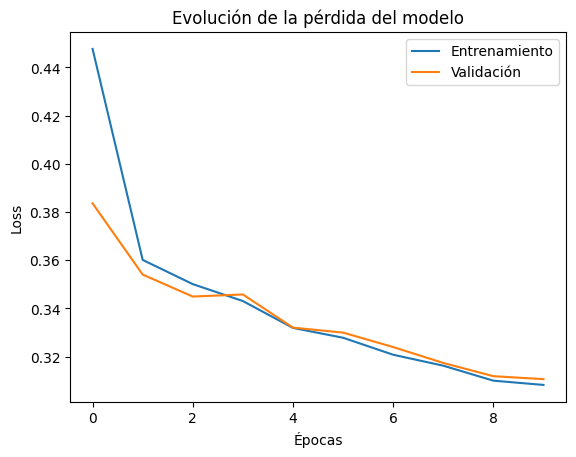

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Entrenamiento")
plt.plot(history.history["val_loss"], label="Validación")
plt.legend()
plt.title("Evolución de la pérdida del modelo")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.show()


In [24]:
model.save("/content/drive/MyDrive/unet_polyp_model.h5")
print("Modelo guardado correctamente en Google Drive")



Modelo guardado correctamente en Google Drive
